# Beamforming Experiments
> Pin-Jung Lee, 21 Jul 2023 -

This notebook mainly serves as a site of experimentation for functionalities of the pyroomacoustics library.

### Tasks completed:
- import relevant libraries
- create functionalities to:
    - load local audio*
    - generate AWGN signals for interferers*
- set up room with appropriate dimensions and microphone/source configuration

### Ongoing:
- introducing interferer sources

### To-do:
- implement rake MVDR algorithm
- modify relevant parameters (SNR, position of interferers)
- update dev details to [Github repo](https://github.com/mondo-lee/pyroomfiddling)
- refactor variables, remove magic numbers, write docstrings (general housekeeping)
- generalise interferer positions while keeping SNR values accurate

*<sup>(To be modified once DL implementation begins)</sup>

In [135]:
### importing libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
import os

In [136]:
### Loading audio data, referring to forum post below
# https://stackoverflow.com/questions/27659563/reading-wav-files-in-all-subdirectories

def load_audio(data_dir):
    '''
    Reads audio from given directory path, returning the sampling frequencies and signals in respective lists.
    
    Inputs:
    data_dir (string): string of directory path of audio sample folder

    Output:
    fs_s (Python list(int16)): list of sampling frequency for each sample
    signals (Python list(int16)): list of signals in form of integers
    '''
    
    fs_s = []
    signals = []

    for root,sub,files in os.walk(data_dir):
        files = sorted(files)
        for f in files:
            fs, signal = wavfile.read(os.path.join(root, f))
            fs_s.append(fs)
            signals.append(signal)
            
    return fs_s, signals

data_dir=r'C:\Users\mondo\Downloads\pyroomfiddling\abridged_samples'
fs_s, signals = load_audio(data_dir)

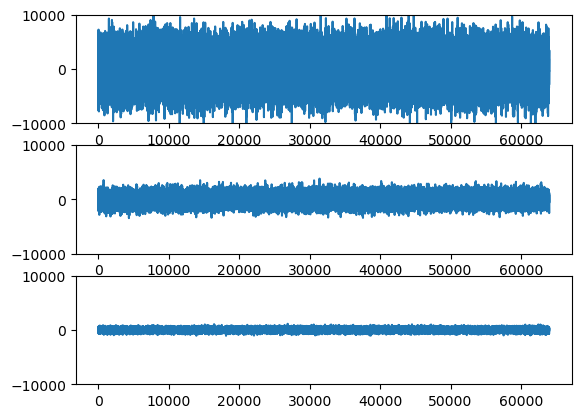

In [137]:
### generate AWGN of desired SNR, referencing the link below
# https://www.rfwireless-world.com/source-code/Python/AWGN-python-script.html

def generate_AWGN(signal, target_snr_db):
    '''
    Produces AWGN with specified SNR to the signal source
    
    Inputs:
        signal (Numpy Array(int16)): read using scipy.io.wavfile.read
        target_snr_db (float): SNR to signal source in dB
    '''

    epsilon = np.finfo(float).eps

    signal = signal.astype('int32') # prevent overflow error

    x_power       = amplitude ** 2 + epsilon # prevent log by 0
    sig_avg_power = np.mean(x_power)
    sig_avg_db    = 10 * np.log10(sig_avg_power)

    noise_avg_db    = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    
    mean_noise = 0
    noise = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(amplitude))
    
    return noise


### demoing generate_AWGN

fig, axes = plt.subplots(3)

for i in range(3):
    axes[i].plot(generate_AWGN(signals[0],10*i))
    axes[i].set_ylim([-10000,10000])

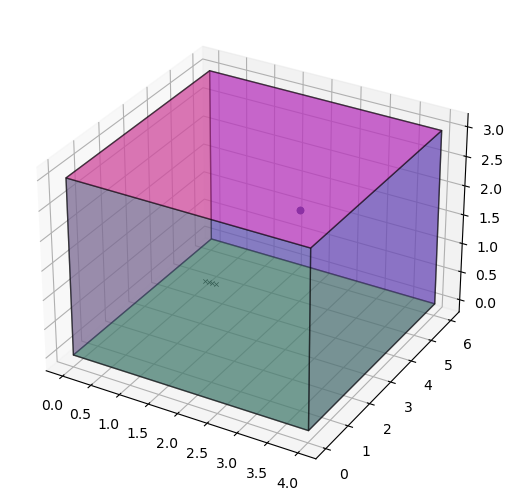

In [89]:
### defining room

rt60 = 0.5 # seconds
room_dim = [4, 6, 3] # meters

e_absorption, max_order = pra.inverse_sabine(rt60, room_dim)

room = pra.ShoeBox(
    room_dim,
    fs=fs_s[0],
    #max_order=10, # order of reverberation
    max_order=max_order,
    #materials=pra.Material("hard_surface"),
    materials=pra.Material(e_absorption),
    humidity=30, # relative humidity (%)
    air_absorption=True,
    use_rand_ism=True
)

room.set_ray_tracing(receiver_radius=0.1, n_rays=10000, energy_thres=1e-5) ## receiver radius?

### setting source

room.add_source([2, 5, 1.4], signal=signals[0])

### setting microphone array

num_mics = 4
width = 0.18
R = []

for i in range(num_mics):
    R.append([np.linspace(2-width/2, 2+width/2, num_mics)[i], 1, 1.5])
    
R = np.c_[R].T # numpy stacked array, transposed to have a x-array, a y-array, and a z-array

bf = pra.Beamformer(R, room.fs)

room.add_microphone_array(bf)

### displaying using matplotlib

fig, ax = room.plot()
ax.auto_scale_xyz([0, 4], [0, 6], [0, 3])
#room.mic_array.rake_mvdr_filters(room.sources[0][:1], interferer, R_n, delay=0.03, epsilon=0.005)

room.simulate(reference_mic=0, snr=10)

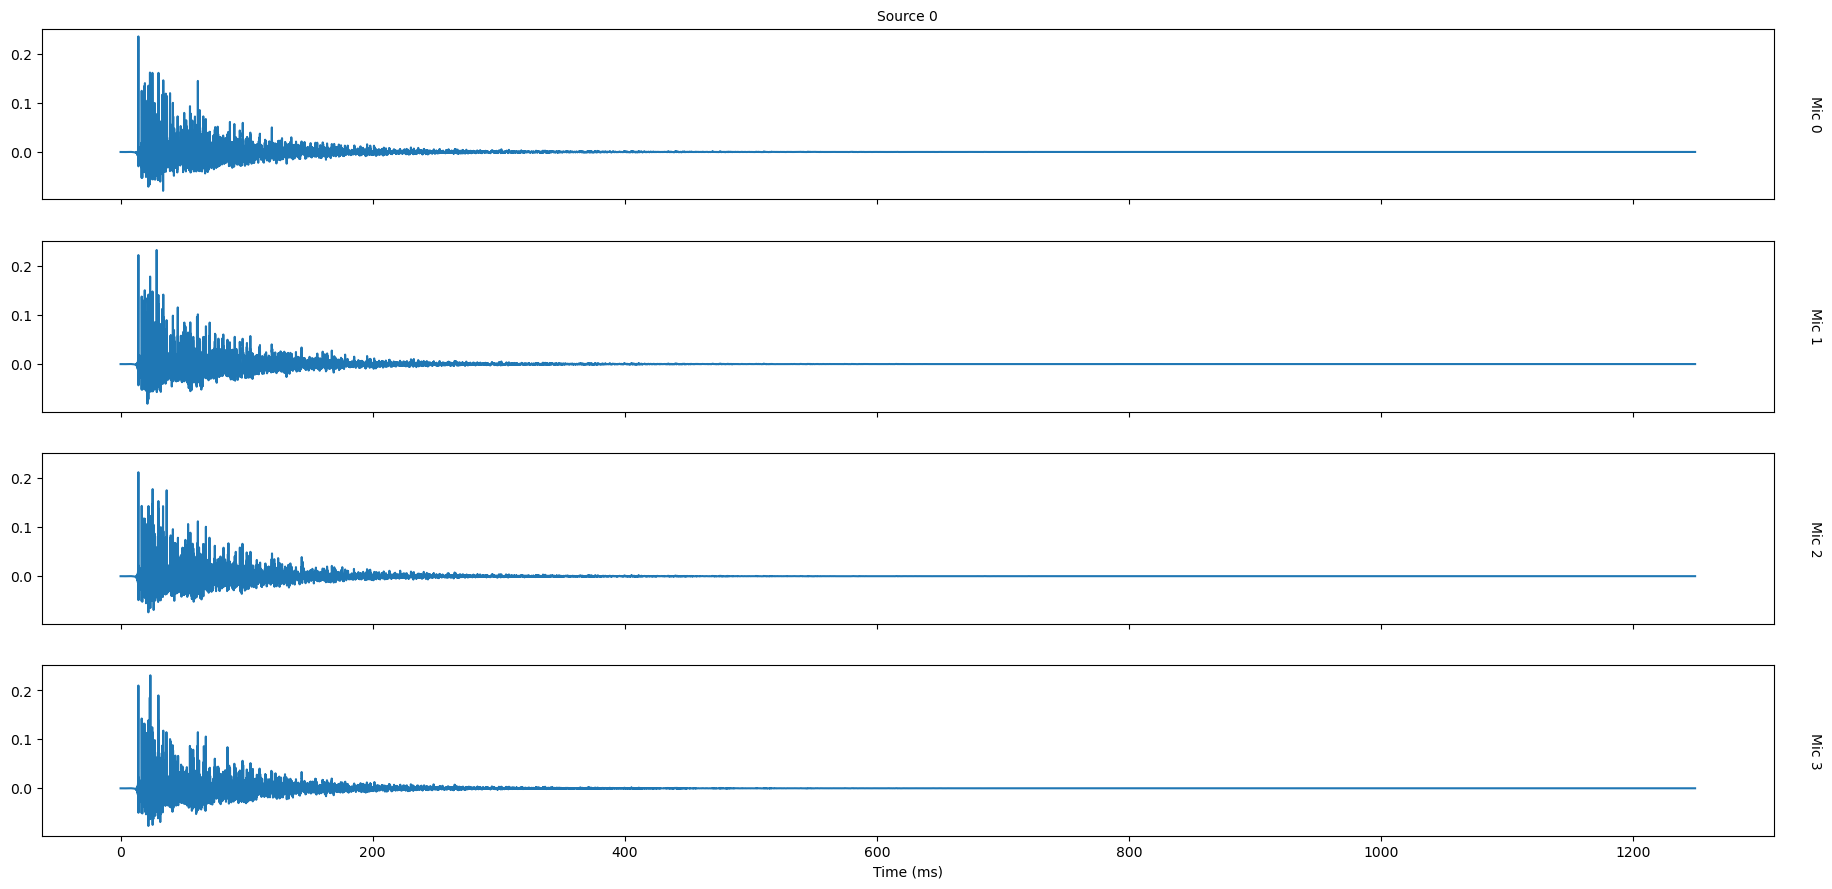

In [90]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20,10)

The RT60 is 665 ms


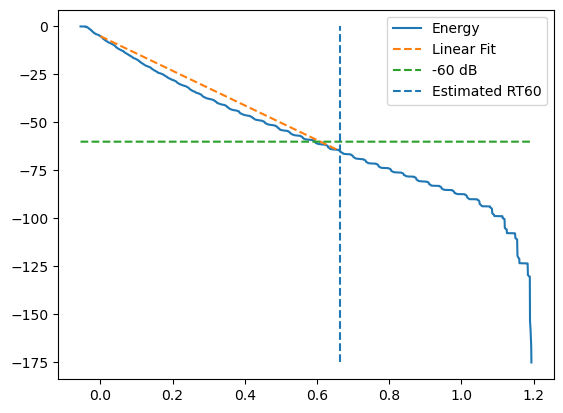

In [91]:
t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=True)
print(f"The RT60 is {t60 * 1000:.0f} ms")

In [92]:
IPython.display.Audio(signals[0], rate=fs_s[0])

In [93]:
IPython.display.Audio(room.mic_array.signals[0,:len(signals[0])],rate=fs_s[0]) # trim to match length of audio

[Desmos Plot. Also Known As: A Few Minutes Of My Life I Will Never Get Back](https://www.desmos.com/calculator/1ghp6okqlf)

In [134]:
target_snr_db = 15 # SNR in dB
max_angle = 20 * np.pi / 180 # range of interferer angles in dB
num_interferers = 2 # number of interferers

### calculating interferer positions

int_theta = np.linspace(-max_angle,max_angle,num_interferers)

int_xy = [0]

print(type(())

receiver_pos = [2,1]

for i in range(num_interferers):
    int_xy = int_xy.append([2 + 4 * np.sin(int_theta), 1 + 4 * np.cos(int_theta)])

print(int_xy)
    
interferers = np.append(int_xy, np.ones(num_interferers).T, 1)

### adding interferers



room.add_source([2, 5, 1.4], signal=signals[0])

AttributeError: 'NoneType' object has no attribute 'append'